# Exploration of dataset

### Install needed dependency

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Helper functions

In [203]:
def make_histogram(df: pd.DataFrame, variable: str, binwidth: int, lower_limit: int = None, upper_limit: int = None) -> None:
    if upper_limit is None:
        upper_limit = df[variable].max()

    if lower_limit is None:
        lower_limit = df[variable].min()

    bins = np.arange(lower_limit, upper_limit + binwidth, binwidth)

    plt.hist(df[variable], bins=bins, edgecolor='black',
             alpha=0.75, range=[df[variable].min(), upper_limit])

    plt.ylabel("Count")
    plt.xlabel(variable.title)


def make_scatter_plot(df: pd.DataFrame, paramOne: str, paramTwo: str, logx: bool = False, logy: bool = False):
    plt.plot(df[paramOne], df[paramTwo], '*', alpha=0.1)
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale('log')
    plt.xlabel(paramOne)
    plt.ylabel(paramTwo)


def corr_heatmap(df: pd.DataFrame, figsize=(10, 10)):
    _, axs = plt.subplots(figsize=figsize)
    ax = sns.heatmap(
        df.corr(), vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True, ax=axs)
    ax.set_title('Correlation matrix')
    return ax


def min_max_normalize(data: pd.DataFrame) -> pd.DataFrame:
    normalize_df = (data - data.min()) / (data.max() - data.min())
    return normalize_df


## Import dataset

I am also dropping passengerId, because its the same as rownumber / but not zero-indexed.

In [204]:
dataframe = pd.read_csv('Titanic.csv')
# Dropping Passenger ID because its the same as rowkey - but indexed from 1.
dataframe.drop('PassengerId', axis=1, inplace=True)

## Explore Data

In [205]:
dataframe.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [206]:
dataframe.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [207]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [208]:
dataframe.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### ANOVA test & missing values
Because the 'Age' column has missing data, the ANOVA test will produce 'nan' (not a number) as the result. To fix this, the missing values in the 'Age' column must be filled in.

There are several common methods for filling in missing data, such as using the mean, median, or mode of the data. These methods work well when the data are normally distributed, but may not be as effective for data with a different distribution.

In the case of the 'Age' column, the data appear to be skewed to the right, with a long tail of older passengers. This suggests that the median may be a better choice for filling in the missing values, as it is less affected by outliers than the mean.

When performing the ANOVA test, the resulting p-value indicates the significance of the differences between the columns. A low p-value indicates that there is a significant difference between at least two of the columns. This suggests that the columns are not all equivalent, and that some further analysis may be needed to understand the underlying patterns in the data.

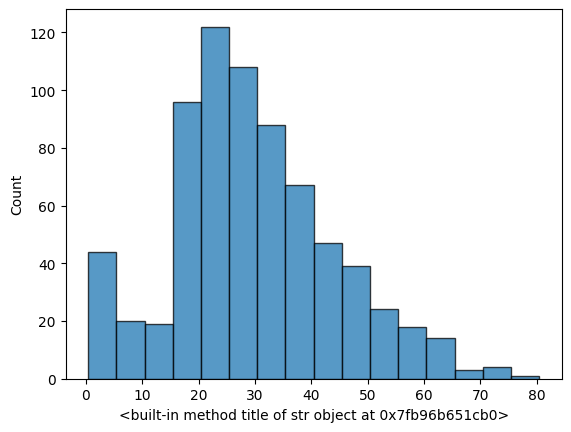

In [209]:
make_histogram(dataframe, variable='Age', binwidth=5)

In [210]:
dataframe['Age'] = dataframe['Age'].fillna(dataframe['Age'].median())

In [211]:
selected_columns = dataframe[['Survived', 'Age', 'Fare']]
f_val, p_val = stats.f_oneway(*selected_columns.to_numpy().T)

print('F-Value:{0:.5f}'.format(f_val))
print('P-Value:{0:.16f}'.format(p_val))

F-Value:314.02684
P-Value:0.0000000000000000


### More missing values

To improve the quality of the data, some processing will be necessary. One common method for filling in missing values is to use random values from the dataset. However, this approach may not be suitable for the 'Cabin' column, since there are a large number of unique values and a large amount of missing data. Instead, it may be more effective to fill in the missing cabin values with a single value, such as 'Unknown'. This will preserve the rows with missing data, while still indicating that the values represent a distinct category of data.

For the 'Embarked' column, which has only two missing values, it may be more efficient to simply fill in the missing values with the most common value in that column. This will ensure that the data are complete, without requiring any additional processing.Some other methods used to fill values is taking random values from the dataset and fill inn. But int the case of cabin, theres alot of unique values, and alot of missing data, so this would not be a good idea.

In [212]:
dataframe['Cabin'] = dataframe['Cabin'].fillna('Unknown')
dataframe['Embarked'] = dataframe['Embarked'].fillna(method='ffill')
dataframe.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

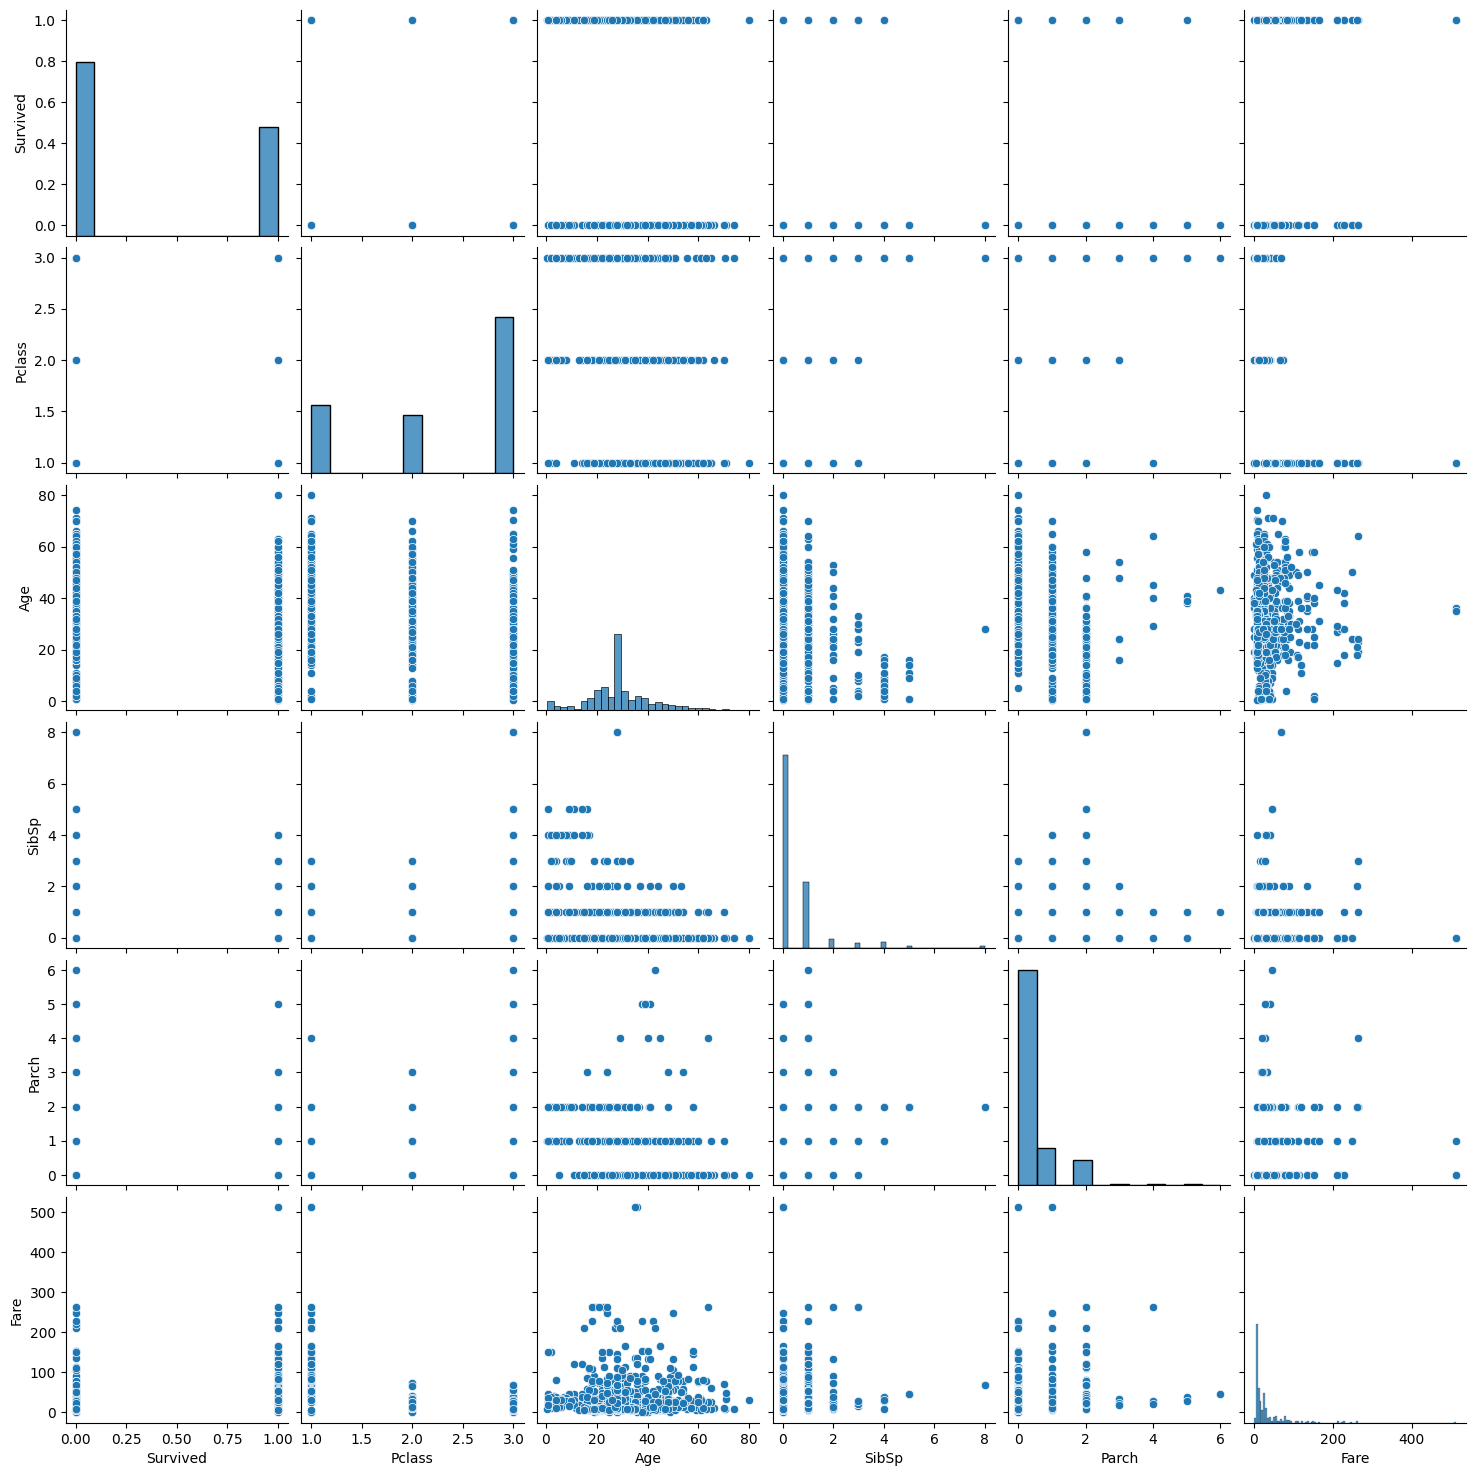

In [213]:
sns.pairplot(dataframe)

#### Further processing

To perform further analysis of the data, it may be useful to encode the data using different methods. One common method is OneHotEncoding, which is useful when there are two or many different values in a column. With OneHotEncoding, a new binary column is created for each category of data, with a boolean flag as the values. 

I will use OneHotEncoding for 'Sex' and 'Embarked'. In the case of the 'Cabin' column, which has many unique values, using the LabelEncoder can help to reduce the number of columns that would be created if OneHotEncoding were used instead. This can make the dataset more manageable, and allow for more efficient analysis.

In [215]:
sex_dummies = pd.get_dummies(dataframe['Sex'])
dataframe = pd.concat([dataframe, sex_dummies], axis=1)
dataframe.drop('Sex', axis=1, inplace=True)

In [216]:
embarked_dummies = pd.get_dummies(dataframe['Embarked'])
dataframe = pd.concat([dataframe, embarked_dummies], axis=1)
dataframe.drop('Embarked', axis=1, inplace=True)

dataframe.rename(columns={ 'C': 'Cherbourg', 'S': 'Southampton', 'Q': 'Queenstown'}, inplace=True)

In [231]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoded_cabin = encoder.fit_transform(dataframe['Cabin'])
dataframe['Cabin'] = encoded_cabin

dataframe['Ticket'].fillna('Unknown', inplace=True)
encoded_ticket = encoder.fit_transform(dataframe['Ticket'])
dataframe['Ticket'] = encoded_ticket

In [232]:
dataframe.head()

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,female,male,Cherbourg,Queenstown,Southampton
0,0,3,"Braund, Mr. Owen Harris",22.0,1,0,523,7.2500,147,0,1,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,596,71.2833,81,1,0,1,0,0
2,1,3,"Heikkinen, Miss. Laina",26.0,0,0,669,7.9250,147,1,0,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,49,53.1000,55,1,0,0,0,1
4,0,3,"Allen, Mr. William Henry",35.0,0,0,472,8.0500,147,0,1,0,0,1


<AxesSubplot: xlabel='Cherbourg,Southampton,Queenstown'>

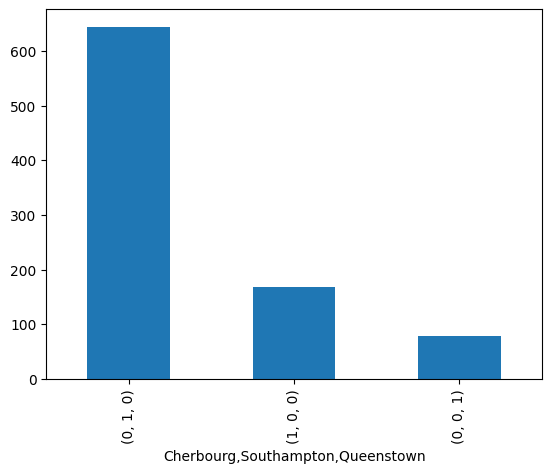

In [233]:
dataframe[['Cherbourg', 'Southampton', 'Queenstown']].value_counts().plot(kind='bar')

<AxesSubplot: >

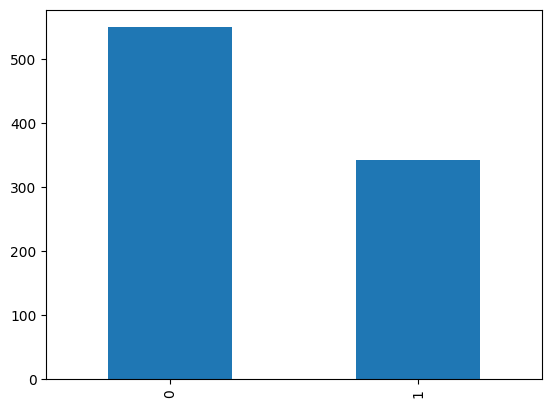

In [234]:
dataframe['Survived'].value_counts().plot(kind='bar')

#### More modifications on the dataset

It would be great to have a family column that includes the parents, children, and spouse of each passenger. In addition, we can add another column indicating whether the passenger traveled alone or not

In [ ]:
dataframe['Family'] = dataframe['Parch'] + dataframe['SibSp']
dataframe['Traveling_Alone'] = dataframe['Family'] == 0

#### Splitting 'Survived' & analyze each group.

In [ ]:
survived_df = dataframe[dataframe['Survived'] == 1]
did_not_survive_df = dataframe[dataframe['Survived'] == 0]

In [ ]:
survived_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,Cherbourg,Queenstown,Southampton,Family
count,342.0,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,1.0,1.950292,28.291433,0.473684,0.464912,48.395408,0.681287,0.318713,0.274854,0.090643,0.634503,0.938596
std,0.0,0.863321,13.764425,0.708688,0.771712,66.596998,0.466660,0.466660,0.447095,0.287522,0.482275,1.186076
min,1.0,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,21.000000,0.000000,0.000000,12.475000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,2.000000,28.000000,0.000000,0.000000,26.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.0,3.000000,35.000000,1.000000,1.000000,57.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000
max,1.0,3.000000,80.000000,4.000000,5.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [ ]:
did_not_survive_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,Cherbourg,Queenstown,Southampton,Family
count,549.0,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000
mean,0.0,2.531876,30.028233,0.553734,0.329690,22.117887,0.147541,0.852459,0.136612,0.085610,0.777778,0.883424
std,0.0,0.735805,12.499986,1.288399,0.823166,31.388207,0.354968,0.354968,0.343751,0.280043,0.416119,1.830669
min,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,2.000000,23.000000,0.000000,0.000000,7.854200,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,0.0,3.000000,28.000000,0.000000,0.000000,10.500000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.0,3.000000,35.000000,1.000000,0.000000,26.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,0.0,3.000000,74.000000,8.000000,6.000000,263.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


In [237]:
did_not_survive_df.median()

/tmp/ipykernel_15504/975274197.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  did_not_survive_df.median()


Survived            0.0
Pclass              3.0
Age                28.0
SibSp               0.0
Parch               0.0
Fare               10.5
female              0.0
male                1.0
Cherbourg           0.0
Queenstown          0.0
Southampton         1.0
Family              0.0
Traveling_Alone     1.0
dtype: float64

In [238]:
survived_df.median()

/tmp/ipykernel_15504/471322627.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  survived_df.median()


Survived            1.0
Pclass              2.0
Age                28.0
SibSp               0.0
Parch               0.0
Fare               26.0
female              1.0
male                0.0
Cherbourg           0.0
Queenstown          0.0
Southampton         1.0
Family              1.0
Traveling_Alone     0.0
dtype: float64